In [3]:
import sys
sys.modules.pop('CLASS_BABY')
sys.modules.pop('CLASS_SAMPLE')


from CLASS_BABY import *
from CLASS_SAMPLE import *

import scipy.stats as ss

#bigger fonts
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rcParams.update({'font.size': 20})

In [4]:
T = pd.read_csv('../TOST_data/average_properties.txt',
            sep='\t',index_col=0,na_values=-99,
            dtype={'WEIGHT_GRAMS': float,
                   'GEST_AGE_DAYS':float,
                   'DELTA_SEC_MEASURE':float,
                   'MED_SPO2':float,
                   'MED_PI':float,
                   'MED_PR':float,
                   'MEAN_SPO2':float,
                   'MEAN_PI':float,
                   'MEAN_PR':float,
                   'STD_SPO2':float,
                   'STD_PI':float,
                   'STD_PR':float,
                   'BRADY_SEC_PR':float,
                   'BRADY_RATIO_PR':float,
                   'BRADY_RATIO_PR_m10':float,
                   'BRADY_RATIO_PR_m20':float,
                   'BRADY_RATIO_PR_m30':float,
                   'BRADY_RATIO_PR_m40':float,
                   'BRADY_SEC_SPO2':float,
                   'BRADY_RATIO_SPO2':float,
                   'BRADY_SEC_PR_DYN':float,
                   'BRADY_RATIO_PR_DYN':float})

# Function to count episode of bradycardia (to be added to the class baby)

In [5]:
def get_brady_episodes_durations(t,PR, threshold=100, duration_min=15,time_step=2):
    '''Return a list containing the duration of the episodes of bradycardia. 
    The length of the list is the number of episodes'''
    
    episode_durations = []
    contiguous_time_bin = True
    counter_sec = 0

    for i in range(1,len(t)):
        if PR[i]< threshold and PR[i-1]< threshold and contiguous_time_bin:
            counter_sec = counter_sec + time_step #sec
        else:
            if counter_sec > duration_min:
                episode_durations.append(counter_sec)
            counter_sec = 0

        if t[i-1] == t[i]-time_step:
            contiguous_time_bin = True
        else:
            contiguous_time_bin = False
    return np.array(episode_durations)
        

# Let's count the episode of bradycardia in a perfect sin function

In [6]:
x = np.arange(0,180,2)
y = np.sin(x/10+2)

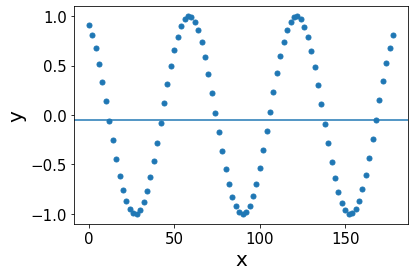

In [7]:
plt.plot(x,y,'.',markersize=10)
plt.axhline(np.mean(y))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
get_brady_episodes_durations(t=x,PR=y,duration_min=15,threshold=0.)

array([30, 28, 30])

In [9]:
#let's check instead when the episodes are less than the duration min
# I should obtain an empty list
get_brady_episodes_durations(t=x,PR=y,duration_min=40,threshold=0.)

array([], dtype=float64)

# Testing on a real baby

In [10]:
B = baby('PLC063',verbose=False)

G_PLC063_Day1_Rt Foot_.csv


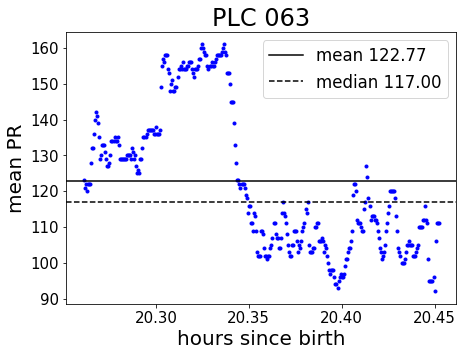

In [11]:
B.plot_baby_measurements(filenumber=0,only_PR=True,with_bad_values=False)

In [12]:
filenumber = 0
time  = np.array(B.measurements_delta_sec_since_birth_list[filenumber])
pulse = np.array(B.measurements[filenumber]['PR'])

sel =  np.where(pulse>10.)

time = time[sel]
pulse = pulse[sel]


#thr = (2./3.)*np.median(pulse)
thr = 110

episodes = get_brady_episodes_durations(t=time,
                                        PR=pulse,
                                        duration_min=15,
                                        threshold=thr)

print('Threshold = ',thr)#,' (2/3 median)')
print('Duration of episodes in seconds = ',episodes)#/60./60.
print('Number of episodes = ',len(episodes))

Threshold =  110
Duration of episodes in seconds =  [32 30 64 16 40]
Number of episodes =  5


In [13]:
B.measurements_bradycardia_episodes_durations[1]

array([28, 16, 54, 20, 26, 22, 22, 20, 18, 28, 20, 26, 30, 36, 30, 18, 16,
       22, 18, 26, 18])

In [14]:
B.measurements_bradycardia_episodes_number[1]

21

In [15]:
b=baby('PLC063')

In [20]:
brady_epi_num = []
brady_epi_dur = []
brady_tot_num_per_sec = []


for name in np.unique(T['BABY_IDS']):
    b = baby(name)
    if b.data_found:
        for i in range(len(b.files)):
            brady_epi_dur.append(b.measurements_bradycardia_episodes_durations[i])
            brady_epi_num.append(b.measurements_bradycardia_episodes_number[i])
            brady_tot_num_per_sec.append(b.measurements_bradycardia_episodes_number_per_sec[i])
            

In [24]:
episodes_per_hour = np.array(brady_tot_num_per_sec)*60.*60.

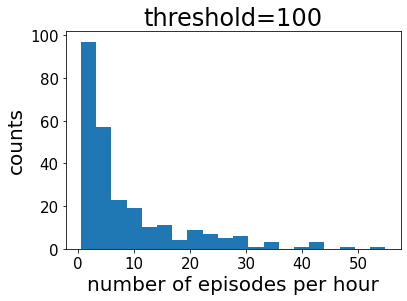

In [30]:
plt.hist(episodes_per_hour[episodes_per_hour!=0.],bins=20)
plt.title('threshold=100')
plt.xlabel('number of episodes per hour')
plt.ylabel('counts')
plt.show()

# Mean - Median as an indication of variabilities in babies

In [41]:
def median_in_bins_err(x,y,x1,x2,nbins,p1=0.25,p2=0.75):
    medians_x = np.zeros(nbins)
    medians_y = np.zeros(nbins)
    err_y_low = np.zeros(nbins)
    err_y_high = np.zeros(nbins)
    x = np.array(x)
    y = np.array(y)
    width = (float(x2)-float(x1))/nbins
    for i in range(int(nbins)):
        x_low = x1 + i*width
        x_high = x1+ (i+1)*width
        #print x_low, x_high
        sel = np.where((x>x_low)&(x<x_high))
        temp_ord = np.copy(y[sel])
        temp_ord = np.sort(temp_ord)
        medians_y[i] = temp_ord[int(len(temp_ord)*0.50 + 0.5)]
        err_y_low[i]  = np.abs(temp_ord[int(len(temp_ord)*p1 + 0.5)]-medians_y[i])
        err_y_high[i]  = np.abs(temp_ord[int(len(temp_ord)*p2 + 0.5)]-medians_y[i])
        #err_y[i] = [err_y_low,err_y_high]
        medians_x[i] = np.median(x[sel])
    return np.array(medians_x),np.array(medians_y),err_y_low,err_y_high

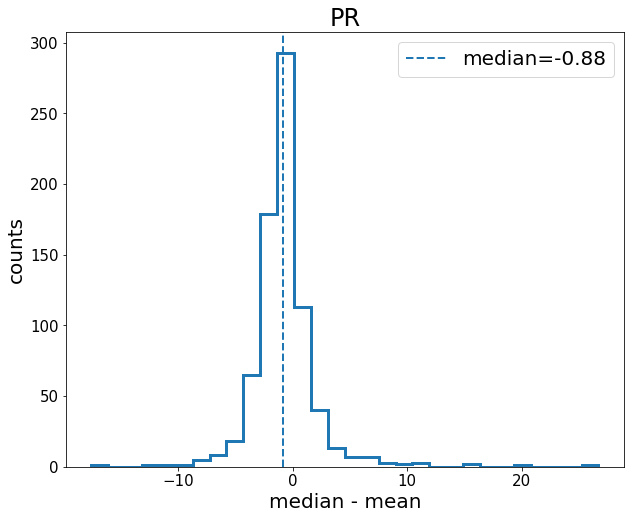

In [31]:
plt.figure(figsize=(10,8))
diff = T['MED_PR']-T['MEAN_PR']
plt.hist(diff,bins=30,histtype='step',lw=3)
plt.axvline(np.median(diff),ls='dashed',lw=2,label='median=%.2f'%np.median(diff))
plt.xlabel('median - mean')
plt.ylabel('counts')
plt.title('PR')
plt.legend()
plt.show()

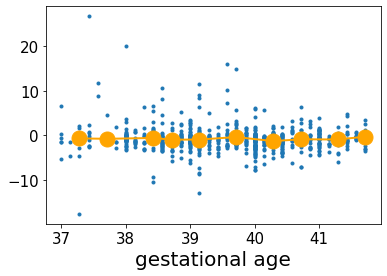

In [52]:
x = T['GEST_AGE_DAYS']/7.
y = diff
plt.plot(x,y,".")
xx,yy,ey1,ey2 = median_in_bins_err(x,y,37,42,10)
plt.errorbar(xx,yy,yerr=[ey1,ey2],fmt=".",markersize=30,elinewidth=3,color='orange',label ='median')
plt.plot(xx,yy,color="orange",lw=2)
plt.xlabel('gestational age')
plt.show()


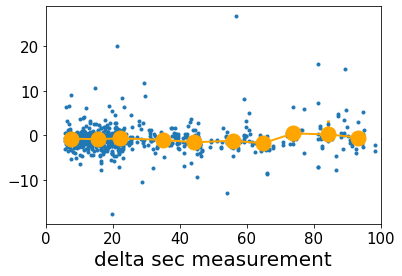

In [54]:
x = T['DELTA_SEC_MEASURE']/60./60.
y = diff 
plt.plot(x,y,".")
xx,yy,ey1,ey2 = median_in_bins_err(x,y,0,100,10)
plt.errorbar(xx,yy,yerr=[ey1,ey2],fmt=".",markersize=30,elinewidth=3,color='orange',label ='median')
plt.plot(xx,yy,color="orange",lw=2)
plt.xlim(0,100)
plt.xlabel('delta sec measurement')

plt.show()


In [32]:
T.columns.values

array(['BABY_IDS', 'GENDER', 'WEIGHT_GRAMS', 'GEST_AGE_DAYS', 'DELIVERY',
       'BIRTH_DATE', 'FILE', 'DELTA_SEC_MEASURE', 'MED_SPO2', 'MED_PR',
       'MED_PI', 'MEAN_SPO2', 'MEAN_PR', 'MEAN_PI', 'STD_SPO2', 'STD_PR',
       'STD_PI', 'PHN', 'WRIST', 'FOOT', 'BRADY_SEC_PR', 'BRADY_RATIO_PR',
       'BRADY_RATIO_PR_m10', 'BRADY_RATIO_PR_m20', 'BRADY_RATIO_PR_m30',
       'BRADY_RATIO_PR_m40', 'BRADY_SEC_SPO2', 'BRADY_RATIO_SPO2',
       'BRADY_SEC_PR_DYN', 'BRADY_RATIO_PR_DYN'], dtype=object)